In [107]:
import napari
from pathlib import Path
import matplotlib

# core pipeline
from config import Settings
from computation import compute
from clustering import separate_shaft_spine, choose_best_clustering, export_grouping_csv
from mapping import export_all

from viz_helpers import (
    plot_branch_and_fiducials,
    plot_markers_along_branch,
    plot_segment_scaling,
    plot_fiducial_index_diagnostics,
    plot_cluster_bins,
)

In [108]:
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple
import csv
import os
import numpy as np
import pandas as pd

from config import Settings
from io_utils import read_branch_csv, read_markers_csv_list, read_fiducials_csv, z_imagej_to_objectj
from geometry import fit_branch_spline, get_xyzs, euc_xy, distance_along_branch


In [109]:
settings = Settings(
        animal_id="SOM022",
        branch_id="4",
        n_timepoints=6,
        branch_csvs={
            "Timepoint 1": Path('/Volumes/nedividata/Amy/files_for_amy_fromJoe/example_analysis_SOM022/SNT_Tracing/Image1/SOM022Image1FullTrace_withbrancheslabeled_xyzCoordinates.csv'),
            "Timepoint 2": Path('/Volumes/nedividata/Amy/files_for_amy_fromJoe/example_analysis_SOM022/SNT_Tracing/Image2/SOM022_Image2_fulltrace_withbrancheslabeled_xyzCoordinates.csv'),
            "Timepoint 3": Path('/Volumes/nedividata/Amy/files_for_amy_fromJoe/example_analysis_SOM022/SNT_Tracing/Image3/SOM022Image3_fulltrace_withbrancheslabeled_xyzCoordinates.csv'),
            "Timepoint 4": Path('/Volumes/nedividata/Amy/files_for_amy_fromJoe/example_analysis_SOM022/SNT_Tracing/Image4/SOM022Image4_fulltrace_withbrancheslabeled_xyzCoordinates.csv'),
            "Timepoint 5": Path('/Volumes/nedividata/Amy/files_for_amy_fromJoe/example_analysis_SOM022/SNT_Tracing/Image5/SOM022Image5_fulltrace_withbrancheslabeled_xyzCoordinates.csv'),
            "Timepoint 6": Path('/Volumes/nedividata/Amy/files_for_amy_fromJoe/example_analysis_SOM022/SNT_Tracing/Image6/SOM022Image6fulltrace_withbrancheslabeled_xyzCoordinates.csv'),
        },
        marker_csvs=[
            Path('/Volumes/nedividata/Amy/files_for_amy_fromJoe/example_analysis_SOM022/PunctaScoring/b3/SynapseMarker/beforeAlignment/SOM022_b3_Image1.csv'),
            Path('/Volumes/nedividata/Amy/files_for_amy_fromJoe/example_analysis_SOM022/PunctaScoring/b3/SynapseMarker/beforeAlignment/SOM022_b3_Image2.csv'),
            Path('/Volumes/nedividata/Amy/files_for_amy_fromJoe/example_analysis_SOM022/PunctaScoring/b3/SynapseMarker/beforeAlignment/SOM022_b3_Image3.csv'),
            Path('/Volumes/nedividata/Amy/files_for_amy_fromJoe/example_analysis_SOM022/PunctaScoring/b3/SynapseMarker/beforeAlignment/SOM022_b3_Image4.csv'),
            Path('/Volumes/nedividata/Amy/files_for_amy_fromJoe/example_analysis_SOM022/PunctaScoring/b3/SynapseMarker/beforeAlignment/SOM022_b3_Image5.csv'),
            Path('/Volumes/nedividata/Amy/files_for_amy_fromJoe/example_analysis_SOM022/PunctaScoring/b3/SynapseMarker/beforeAlignment/SOM022_b3_Image2.csv'),
        ],
        fiducials_csv=Path(''),
        export_dir=Path("exports"),
        scaling_factor=[0.25, 0.25, 1],
        num_channels=4,
        inhibitory_shaft="InhibitoryShaft",
        inhibitory_spine="spinewithInhsynapse",
        ojj_tif_key="Image",
        snt_branch_fmt="b%s",
)

Directly copy pasted from the computation.py file 

In [110]:
def _normalize_and_scale(branch, markers, fiducials, scale):
    minx = min(pt[0] for pt in branch)
    miny = min(pt[1] for pt in branch)
    minz = min(pt[2] for pt in branch)
    def _xf(c):
        return ((c[0] - minx) * scale[0], (c[1] - miny) * scale[1], (c[2] - minz) * scale[2])
    return list(map(_xf, branch)), list(map(_xf, markers)), list(map(_xf, fiducials))


def _branch_points_from_csvs(settings: Settings) -> List[List[Coord]]:
    raw = []
    for i in range(settings.n_timepoints):
        df = read_branch_csv(settings.branch_csvs[f"Timepoint {i+1}"], settings.snt_branch_fmt % settings.branch_id)
        x, y, z = df["x"].values, df["y"].values, df["z"].values
        raw.append(fit_branch_spline(x, y, z, n_points=100))
    return raw


In [111]:
import numpy as np
from typing import List, Callable
import matplotlib.pyplot as plt

# ============================================================
# 0. Basic helpers
# ============================================================

def _to_xy(arr):
    """Ensure array is (N, 2) from (N,), (N,2), (N,3,...)."""
    arr = np.asarray(arr)
    if arr.ndim == 1:
        return np.stack([arr, np.zeros_like(arr)], axis=1)
    if arr.shape[1] >= 2:
        return arr[:, :2]
    pad = np.zeros((arr.shape[0], 1), dtype=arr.dtype)
    return np.hstack([arr, pad])

def compute_arclength(branch_xy: np.ndarray):
    """
    Given branch points (N,2), return:
      s: arclength at each vertex (length N)
      L: total length
      t_norm: normalized arclength in [0,1]
    """
    branch_xy = _to_xy(branch_xy)
    diffs = np.diff(branch_xy, axis=0)
    seglen = np.linalg.norm(diffs, axis=1)
    s = np.concatenate([[0.0], np.cumsum(seglen)])
    L = float(s[-1]) if s[-1] > 0 else 1.0
    t_norm = s / L
    return s, L, t_norm

def resample_branch_equal_arclen(branch_xy: np.ndarray, n_samp: int = 200):
    """
    Resample the branch to n_samp points at equal arclength fractions in [0,1].
    Returns resampled points of shape (n_samp, 2) and the t grid.
    """
    branch_xy = _to_xy(branch_xy)
    s, L, t_norm = compute_arclength(branch_xy)

    t_grid = np.linspace(0.0, 1.0, n_samp)
    x = np.interp(t_grid, t_norm, branch_xy[:, 0])
    y = np.interp(t_grid, t_norm, branch_xy[:, 1])
    pts = np.stack([x, y], axis=1)
    return pts, t_grid

# ============================================================
# 1. Tangent angle representation
# ============================================================

def compute_tangent_angles(branch_xy: np.ndarray,
                           n_samp: int = 200,
                           coord_smooth_window: int = 7,
                           theta_smooth_window: int = 11):
    """
    1) Resample branch to n_samp points along arclength in [0,1].
    2) Optionally smooth coordinates along the curve (coord_smooth_window).
    3) Compute unit tangents via finite differences.
    4) Convert to angles theta in radians, unwrap to avoid π jumps.
    5) Optionally smooth theta as a 1D signal (theta_smooth_window).

    Returns:
        theta_smooth: shape (n_samp,)
        t_grid:       shape (n_samp,) ∈ [0,1]
    """
    pts, t_grid = resample_branch_equal_arclen(branch_xy, n_samp=n_samp)
    N = pts.shape[0]

    # --- 2) Smooth coordinates along arclength (optional) ---
    if coord_smooth_window >= 3 and coord_smooth_window % 2 == 1:
        kernel = np.ones(coord_smooth_window, dtype=float) / coord_smooth_window
        x = np.convolve(pts[:, 0], kernel, mode="same")
        y = np.convolve(pts[:, 1], kernel, mode="same")
        pts_s = np.stack([x, y], axis=1)
    else:
        pts_s = pts

    # --- 3) Tangents via finite differences ---
    diffs = np.zeros_like(pts_s)
    if N >= 2:
        diffs[0]  = pts_s[1] - pts_s[0]
        diffs[-1] = pts_s[-1] - pts_s[-2]
    if N >= 3:
        diffs[1:-1] = (pts_s[2:] - pts_s[:-2]) * 0.5

    norms = np.linalg.norm(diffs, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    tangents = diffs / norms

    theta = np.arctan2(tangents[:, 1], tangents[:, 0])
    theta_unwrapped = np.unwrap(theta)

    # --- 5) Smooth theta itself (optional) ---
    if theta_smooth_window >= 3 and theta_smooth_window % 2 == 1:
        k = np.ones(theta_smooth_window, dtype=float) / theta_smooth_window
        theta_smooth = np.convolve(theta_unwrapped, k, mode="same")
    else:
        theta_smooth = theta_unwrapped

    return theta_smooth, t_grid


# ============================================================
# 2. Simple DTW implementation for 1D sequences
# ============================================================

def dtw_path(seq1: np.ndarray, seq2: np.ndarray):
    """
    Classic DTW for 1D sequences.
    Returns a list of (i, j) indices giving the alignment path.
    """
    seq1 = np.asarray(seq1, dtype=float)
    seq2 = np.asarray(seq2, dtype=float)
    n, m = len(seq1), len(seq2)

    # cost matrix
    D = np.full((n + 1, m + 1), np.inf)
    D[0, 0] = 0.0

    # backpointers: 0 = diag, 1 = up, 2 = left
    trace = np.zeros((n + 1, m + 1), dtype=np.int8)

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = (seq1[i - 1] - seq2[j - 1]) ** 2
            choices = (D[i - 1, j - 1], D[i - 1, j], D[i, j - 1])
            k = int(np.argmin(choices))
            D[i, j] = cost + choices[k]
            trace[i, j] = k

    # backtrack
    i, j = n, m
    path = []
    while i > 0 and j > 0:
        path.append((i - 1, j - 1))
        move = trace[i, j]
        if move == 0:   # diag
            i -= 1
            j -= 1
        elif move == 1: # up
            i -= 1
        else:           # left
            j -= 1

    path.reverse()
    return path

# ============================================================
# 3. Build monotone warping function from DTW path
# ============================================================

def build_warp_from_dtw(t_ref: np.ndarray,
                        t_src: np.ndarray,
                        path: List[tuple]) -> Callable[[float], float]:
    """
    Given:
      t_ref: positions in [0,1] for reference sequence (len n_ref)
      t_src: positions in [0,1] for source sequence (len n_src)
      path: list of (i_ref, j_src) pairs from DTW

    Build a monotone, piecewise-linear warp f: t_src -> t_ref.

    Returns:
      f(t) = interpolated t_ref aligned to this source t.
    """
    # Path is monotone in indices by construction.
    # Build sample pairs (t_src_sample, t_ref_sample) along the path.
    t_src_samples = []
    t_ref_samples = []

    last_src = None
    for i_ref, j_src in path:
        src_t = float(t_src[j_src])
        ref_t = float(t_ref[i_ref])
        if last_src is None or src_t > last_src:
            t_src_samples.append(src_t)
            t_ref_samples.append(ref_t)
            last_src = src_t
        else:
            # If the same src index appears multiple times, we can:
            # - ignore it (already added), or
            # - update the last ref_t (average).
            # Here we just update to the latest ref_t.
            t_ref_samples[-1] = ref_t

    # Ensure endpoints are covered
    if 0.0 not in t_src_samples:
        t_src_samples.insert(0, 0.0)
        t_ref_samples.insert(0, t_ref[0])
    if 1.0 not in t_src_samples:
        t_src_samples.append(1.0)
        t_ref_samples.append(t_ref[-1])

    t_src_arr = np.array(t_src_samples)
    t_ref_arr = np.array(t_ref_samples)

    def warp_func(t: float) -> float:
        return float(np.interp(t, t_src_arr, t_ref_arr,
                               left=t_ref_arr[0],
                               right=t_ref_arr[-1]))

    return warp_func

# ============================================================
# 4. Main pipeline: branches, markers, DTW alignment, canonical distances
# ============================================================

# 4.1 Load raw branch + markers, then normalize & scale
raw_branch = _branch_points_from_csvs(settings)
raw_markers, raw_fids_typed = read_markers_csv_list(
    settings.marker_csvs,
    settings.num_channels
)

# Strip types for markers into parallel arrays
raw_marker_coords_only = [[m[1] for m in tp] for tp in raw_markers]
raw_marker_types_only  = [[m[0] for m in tp] for tp in raw_markers]

# Normalize & scale (no fiducials needed here)
nb, nm = [], []
for i in range(settings.n_timepoints):
    # If _normalize_and_scale needs fiducials, pass an empty list.
    b, m, _ = _normalize_and_scale(
        raw_branch[i],
        raw_marker_coords_only[i],
        [],  # no manual fiducials
        settings.scaling_factor
    )
    nb.append(b)
    nm.append(m)

# 4.2 Map markers to nearest branch vertex (for arclength parameter)
def nearest_indices(points, branch):
    idxs = []
    for p in points:
        dists = [euc_xy(p, q) for q in branch]
        idxs.append(int(np.argmin(dists)))
    return idxs

cb_markers = []
for i in range(settings.n_timepoints):
    cb_markers.append(nearest_indices(nm[i], nb[i]))

# 4.3 Compute arclength + tangent angles for each timepoint
n_samp_theta = 200  # number of samples for angle representation
theta_all = []
tgrid_all = []
s_all = []
L_all = []
t_norm_all = []

for i in range(settings.n_timepoints):
    branch_xy = _to_xy(nb[i])
    # arclength / normalized arclength per vertex
    s_i, L_i, t_norm_i = compute_arclength(branch_xy)
    s_all.append(s_i)
    L_all.append(L_i)
    t_norm_all.append(t_norm_i)

    # tangent angles as function of normalized arclength
    theta_i, t_grid_i = compute_tangent_angles(branch_xy, n_samp=n_samp_theta)
    theta_all.append(theta_i)
    tgrid_all.append(t_grid_i)

# 4.4 Choose reference timepoint and build warp functions with DTW
ref_tp = 0
theta_ref = theta_all[ref_tp]
t_ref_grid = tgrid_all[ref_tp]
L_ref = L_all[ref_tp]

warp_funcs: List[Callable[[float], float]] = []

for tp in range(settings.n_timepoints):
    if tp == ref_tp:
        # Identity mapping for reference
        warp_funcs.append(lambda t, _tgrid=t_ref_grid: float(t))
        continue

    theta_src = theta_all[tp]
    t_src_grid = tgrid_all[tp]

    # DTW between reference and this timepoint in angle space
    path = dtw_path(theta_ref, theta_src)

    # Build monotone warp f_tp: t_src -> t_ref
    f_tp = build_warp_from_dtw(t_ref_grid, t_src_grid, path)
    warp_funcs.append(f_tp)

# 4.5 Compute canonical marker distances along reference branch
#     final_marker_distance[tp][k] ~ distance along reference branch (0..L_ref)
final_marker_distance: List[List[float]] = []

for tp in range(settings.n_timepoints):
    branch_xy = _to_xy(nb[tp])
    s_i, L_i, t_norm_i = compute_arclength(branch_xy)  # recompute or reuse t_norm_all[tp]
    f_tp = warp_funcs[tp]

    fm = []
    for m_idx in cb_markers[tp]:
        # 1D parameter of marker along this branch (normalized [0,1])
        t_marker = float(t_norm_i[m_idx])
        # Warp into reference's parameter space
        t_canon = f_tp(t_marker)
        # Convert to distance along reference branch
        d_canon = t_canon * L_ref
        fm.append(d_canon)
    final_marker_distance.append(fm)

# ============================================================
# 5. Optional plotting helpers
# ============================================================

def plot_theta_alignment(tp: int = 1):
    """
    Visualize tangent-angle signals for reference vs another timepoint.
    Helps debug the DTW alignment.
    """
    theta_ref = theta_all[ref_tp]
    t_ref = tgrid_all[ref_tp]
    theta_src = theta_all[tp]
    t_src = tgrid_all[tp]

    plt.figure(figsize=(6, 4))
    plt.plot(t_ref, theta_ref, label=f"theta ref (tp={ref_tp+1})")
    plt.plot(t_src, theta_src, label=f"theta tp={tp+1}", alpha=0.7)
    plt.xlabel("normalized arclength t")
    plt.ylabel("tangent angle (rad, unwrapped)")
    plt.title("Tangent-angle profiles")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_branch_with_marker_coords(tp: int = 0):
    """
    Plot branch with markers colored by canonical distance final_marker_distance.
    """
    branch_xy = _to_xy(nb[tp])
    markers = nm[tp]
    m_idxs = cb_markers[tp]
    fm = final_marker_distance[tp]

    plt.figure(figsize=(5, 5))
    plt.plot(branch_xy[:, 0], branch_xy[:, 1], "-o", ms=2, lw=1, label="branch")
    if markers:
        markers_xy = np.array(markers)
        sc = plt.scatter(markers_xy[:, 0], markers_xy[:, 1],
                         c=fm, s=20, cmap="viridis", label="markers (canon. dist)")
        plt.colorbar(sc, label="canonical distance along ref branch")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")
    plt.title(f"Timepoint {tp+1}: markers colored by canonical distance")
    plt.legend()
    plt.tight_layout()
    plt.show()


[markers] Timepoint 1: 10 markers, 9 landmarks.
[markers] Timepoint 2: 9 markers, 9 landmarks.
[markers] Timepoint 3: 8 markers, 9 landmarks.
[markers] Timepoint 4: 22 markers, 9 landmarks.
[markers] Timepoint 5: 12 markers, 9 landmarks.
[markers] Timepoint 6: 0 markers, 0 landmarks.


In [112]:
import numpy as np
from typing import List, Callable
import matplotlib.pyplot as plt
from scipy.signal import find_peaks  # NEW: for curvature peak detection

# ============================================================
# 0. Basic helpers
# ============================================================

def _to_xy(arr):
    """Ensure array is (N, 2) from (N,), (N,2), (N,3,...)."""
    arr = np.asarray(arr)
    if arr.ndim == 1:
        return np.stack([arr, np.zeros_like(arr)], axis=1)
    if arr.shape[1] >= 2:
        return arr[:, :2]
    pad = np.zeros((arr.shape[0], 1), dtype=arr.dtype)
    return np.hstack([arr, pad])

def compute_arclength(branch_xy: np.ndarray):
    """
    Given branch points (N,2), return:
      s: arclength at each vertex (length N)
      L: total length
      t_norm: normalized arclength in [0,1]
    """
    branch_xy = _to_xy(branch_xy)
    diffs = np.diff(branch_xy, axis=0)
    seglen = np.linalg.norm(diffs, axis=1)
    s = np.concatenate([[0.0], np.cumsum(seglen)])
    L = float(s[-1]) if s[-1] > 0 else 1.0
    t_norm = s / L
    return s, L, t_norm

def resample_branch_equal_arclen(branch_xy: np.ndarray, n_samp: int = 200):
    """
    Resample the branch to n_samp points at equal arclength fractions in [0,1].
    Returns resampled points of shape (n_samp, 2) and the t grid.
    """
    branch_xy = _to_xy(branch_xy)
    s, L, t_norm = compute_arclength(branch_xy)

    t_grid = np.linspace(0.0, 1.0, n_samp)
    x = np.interp(t_grid, t_norm, branch_xy[:, 0])
    y = np.interp(t_grid, t_norm, branch_xy[:, 1])
    pts = np.stack([x, y], axis=1)
    return pts, t_grid

# ============================================================
# 1. Tangent angle representation
# ============================================================

def compute_tangent_angles(branch_xy: np.ndarray,
                           n_samp: int = 200,
                           coord_smooth_window: int = 7,
                           theta_smooth_window: int = 11):
    """
    1) Resample branch to n_samp points along arclength in [0,1].
    2) Optionally smooth coordinates along the curve (coord_smooth_window).
    3) Compute unit tangents via finite differences.
    4) Convert to angles theta in radians, unwrap to avoid π jumps.
    5) Optionally smooth theta as a 1D signal (theta_smooth_window).

    Returns:
        theta_smooth: shape (n_samp,)
        t_grid:       shape (n_samp,) ∈ [0,1]
    """
    pts, t_grid = resample_branch_equal_arclen(branch_xy, n_samp=n_samp)
    N = pts.shape[0]

    # --- 2) Smooth coordinates along arclength (optional) ---
    if coord_smooth_window >= 3 and coord_smooth_window % 2 == 1:
        kernel = np.ones(coord_smooth_window, dtype=float) / coord_smooth_window
        x = np.convolve(pts[:, 0], kernel, mode="same")
        y = np.convolve(pts[:, 1], kernel, mode="same")
        pts_s = np.stack([x, y], axis=1)
    else:
        pts_s = pts

    # --- 3) Tangents via finite differences ---
    diffs = np.zeros_like(pts_s)
    if N >= 2:
        diffs[0]  = pts_s[1] - pts_s[0]
        diffs[-1] = pts_s[-1] - pts_s[-2]
    if N >= 3:
        diffs[1:-1] = (pts_s[2:] - pts_s[:-2]) * 0.5

    norms = np.linalg.norm(diffs, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    tangents = diffs / norms

    theta = np.arctan2(tangents[:, 1], tangents[:, 0])
    theta_unwrapped = np.unwrap(theta)

    # --- 5) Smooth theta itself (optional) ---
    if theta_smooth_window >= 3 and theta_smooth_window % 2 == 1:
        k = np.ones(theta_smooth_window, dtype=float) / theta_smooth_window
        theta_smooth = np.convolve(theta_unwrapped, k, mode="same")
    else:
        theta_smooth = theta_unwrapped

    return theta_smooth, t_grid

# ============================================================
# 1b. Curvature-like scores for curvature landmarks
# ============================================================

def curvature_scores_along_branch(branch_xy: np.ndarray,
                                  n_samp: int = 200,
                                  coord_smooth_window: int = 9,
                                  curv_smooth_window: int = 9):
    """
    Compute a smooth 'curvature magnitude' signal κ(t) along normalized arclength
    for a single branch.

    Steps:
      1) Resample branch to n_samp points at equal arclength fractions t ∈ [0,1].
      2) Smooth coordinates along the curve.
      3) Compute discrete second derivative p[i+1] - 2 p[i] + p[i-1].
      4) Use ||second derivative|| as a curvature-like magnitude.
      5) Smooth κ(t) as a 1D signal.

    Returns:
      kappa_smooth: shape (n_samp,) curvature-like score
      t_grid:       shape (n_samp,) ∈ [0,1]
    """
    pts, t_grid = resample_branch_equal_arclen(branch_xy, n_samp=n_samp)
    N = pts.shape[0]

    # --- smooth coordinates ---
    if coord_smooth_window >= 3 and coord_smooth_window % 2 == 1:
        kcoord = np.ones(coord_smooth_window, dtype=float) / coord_smooth_window
        x = np.convolve(pts[:, 0], kcoord, mode="same")
        y = np.convolve(pts[:, 1], kcoord, mode="same")
        pts_s = np.stack([x, y], axis=1)
    else:
        pts_s = pts

    # --- second derivative (index-wise) ---
    d2 = np.zeros((N, 2), dtype=float)
    if N >= 3:
        core = pts_s[2:, :] - 2 * pts_s[1:-1, :] + pts_s[:-2, :]
        d2[1:-1, :] = core

    kappa = np.linalg.norm(d2, axis=1)

    # --- smooth curvature signal ---
    if curv_smooth_window >= 3 and curv_smooth_window % 2 == 1:
        kcurv = np.ones(curv_smooth_window, dtype=float) / curv_smooth_window
        kappa_smooth = np.convolve(kappa, kcurv, mode="same")
    else:
        kappa_smooth = kappa

    return kappa_smooth, t_grid

# ============================================================
# 2. Simple DTW implementation for 1D sequences
# ============================================================

def dtw_path(seq1: np.ndarray, seq2: np.ndarray):
    """
    Classic DTW for 1D sequences.
    Returns a list of (i, j) indices giving the alignment path.
    """
    seq1 = np.asarray(seq1, dtype=float)
    seq2 = np.asarray(seq2, dtype=float)
    n, m = len(seq1), len(seq2)

    # cost matrix
    D = np.full((n + 1, m + 1), np.inf)
    D[0, 0] = 0.0

    # backpointers: 0 = diag, 1 = up, 2 = left
    trace = np.zeros((n + 1, m + 1), dtype=np.int8)

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = (seq1[i - 1] - seq2[j - 1]) ** 2
            choices = (D[i - 1, j - 1], D[i - 1, j], D[i, j - 1])
            k = int(np.argmin(choices))
            D[i, j] = cost + choices[k]
            trace[i, j] = k

    # backtrack
    i, j = n, m
    path = []
    while i > 0 and j > 0:
        path.append((i - 1, j - 1))
        move = trace[i, j]
        if move == 0:   # diag
            i -= 1
            j -= 1
        elif move == 1: # up
            i -= 1
        else:           # left
            j -= 1

    path.reverse()
    return path

# ============================================================
# 3. Build monotone warping function from DTW path
# ============================================================

def build_warp_from_dtw(t_ref: np.ndarray,
                        t_src: np.ndarray,
                        path: List[tuple]):
    """
    Given:
      t_ref: positions in [0,1] for reference sequence (len n_ref)
      t_src: positions in [0,1] for source sequence (len n_src)
      path: list of (i_ref, j_src) pairs from DTW

    Build a monotone, piecewise-linear warp f: t_src -> t_ref.

    Returns:
      warp_func(t) -> t_ref
      t_src_arr: sample t_src points used
      t_ref_arr: corresponding t_ref points
    """
    # Path is monotone in indices by construction.
    t_src_samples = []
    t_ref_samples = []

    last_src = None
    for i_ref, j_src in path:
        src_t = float(t_src[j_src])
        ref_t = float(t_ref[i_ref])
        if last_src is None or src_t > last_src:
            t_src_samples.append(src_t)
            t_ref_samples.append(ref_t)
            last_src = src_t
        else:
            # multiple matches to the same src index: update last ref_t
            t_ref_samples[-1] = ref_t

    # Ensure endpoints are covered
    if 0.0 not in t_src_samples:
        t_src_samples.insert(0, 0.0)
        t_ref_samples.insert(0, t_ref[0])
    if 1.0 not in t_src_samples:
        t_src_samples.append(1.0)
        t_ref_samples.append(t_ref[-1])

    t_src_arr = np.array(t_src_samples)
    t_ref_arr = np.array(t_ref_samples)

    def warp_func(t: float) -> float:
        return float(np.interp(t, t_src_arr, t_ref_arr,
                               left=t_ref_arr[0],
                               right=t_ref_arr[-1]))

    return warp_func, t_src_arr, t_ref_arr

# ============================================================
# 4. Main pipeline: branches, markers, DTW alignment, canonical distances
# ============================================================

# 4.1 Load raw branch + markers, then normalize & scale
raw_branch = _branch_points_from_csvs(settings)
raw_markers, raw_fids_typed = read_markers_csv_list(
    settings.marker_csvs,
    settings.num_channels
)

# Strip types for markers into parallel arrays
raw_marker_coords_only = [[m[1] for m in tp] for tp in raw_markers]
raw_marker_types_only  = [[m[0] for m in tp] for tp in raw_markers]

# Normalize & scale (no manual fiducials needed)
nb, nm = [], []
for i in range(settings.n_timepoints):
    b, m, _ = _normalize_and_scale(
        raw_branch[i],
        raw_marker_coords_only[i],
        [],  # no manual fiducials
        settings.scaling_factor
    )
    nb.append(b)
    nm.append(m)

# 4.2 Map markers to nearest branch vertex (for arclength parameter)
def nearest_indices(points, branch):
    idxs = []
    for p in points:
        dists = [euc_xy(p, q) for q in branch]
        idxs.append(int(np.argmin(dists)))
    return idxs

cb_markers = []
for i in range(settings.n_timepoints):
    cb_markers.append(nearest_indices(nm[i], nb[i]))

# 4.3 Compute arclength + tangent angles for each timepoint
n_samp_theta = 200  # number of samples for angle representation
theta_all = []
tgrid_all = []
s_all = []
L_all = []
t_norm_all = []

for i in range(settings.n_timepoints):
    branch_xy = _to_xy(nb[i])
    s_i, L_i, t_norm_i = compute_arclength(branch_xy)
    s_all.append(s_i)
    L_all.append(L_i)
    t_norm_all.append(t_norm_i)

    theta_i, t_grid_i = compute_tangent_angles(
        branch_xy,
        n_samp=n_samp_theta,
        coord_smooth_window=7,
        theta_smooth_window=11,
    )
    theta_all.append(theta_i)
    tgrid_all.append(t_grid_i)

# 4.4 Choose reference timepoint and build warp functions with DTW
ref_tp = 0
theta_ref = theta_all[ref_tp]
t_ref_grid = tgrid_all[ref_tp]
L_ref = L_all[ref_tp]

warp_funcs: List[Callable[[float], float]] = []
warp_src_samples: List[np.ndarray] = []  # per-tp t_src_arr
warp_ref_samples: List[np.ndarray] = []  # per-tp t_ref_arr

for tp in range(settings.n_timepoints):
    if tp == ref_tp:
        warp_funcs.append(lambda t, _tg=t_ref_grid: float(t))
        warp_src_samples.append(t_ref_grid.copy())
        warp_ref_samples.append(t_ref_grid.copy())
        continue

    theta_src = theta_all[tp]
    t_src_grid = tgrid_all[tp]

    path = dtw_path(theta_ref, theta_src)
    f_tp, t_src_arr, t_ref_arr = build_warp_from_dtw(t_ref_grid, t_src_grid, path)
    warp_funcs.append(f_tp)
    warp_src_samples.append(t_src_arr)
    warp_ref_samples.append(t_ref_arr)

# 4.5 Compute canonical marker distances along reference branch
final_marker_distance: List[List[float]] = []

for tp in range(settings.n_timepoints):
    branch_xy = _to_xy(nb[tp])
    s_i, L_i, t_norm_i = compute_arclength(branch_xy)
    f_tp = warp_funcs[tp]

    fm = []
    for m_idx in cb_markers[tp]:
        t_marker = float(t_norm_i[m_idx])  # normalized arclength
        t_canon = f_tp(t_marker)          # in reference t-space
        d_canon = t_canon * L_ref         # distance along reference branch
        fm.append(d_canon)
    final_marker_distance.append(fm)

# ============================================================
# 5. Curvature-based DTW-derived landmarks (new fiducials)
# ============================================================

end_clip_frac    = 0.08     # ignore first/last 8% of arclength
min_peak_frac    = 0.25     # keep peaks >= 25% of max curvature
min_idx_sep_frac = 0.10     # peaks must be at least 10% of samples apart
max_landmarks    = 3        # hard cap on number of curvature landmarks
fallback_K       = 2        # if everything fails, use this many evenly spaced

# --- 5.1: Find curvature-based landmarks ON THE REFERENCE BRANCH ONLY ---

branch_ref_xy = _to_xy(nb[ref_tp])

kappa_ref, t_ref_curv = curvature_scores_along_branch(
    branch_ref_xy,
    n_samp=200,
    coord_smooth_window=11,
    curv_smooth_window=11,
)

kappa_for_peaks = kappa_ref.copy()
tip_mask = (t_ref_curv <= end_clip_frac) | (t_ref_curv >= 1.0 - end_clip_frac)
kappa_for_peaks[tip_mask] = 0.0

min_idx_sep = max(1, int(len(kappa_for_peaks) * min_idx_sep_frac))

peaks_all, _ = find_peaks(kappa_for_peaks, distance=min_idx_sep)

if len(peaks_all) == 0:
    # fallback: branch is nearly straight or too noisy
    t_ref_landmarks = np.linspace(0.0, 1.0, fallback_K + 2)[1:-1]
else:
    peak_vals = kappa_for_peaks[peaks_all]
    max_val   = float(peak_vals.max())
    height_thresh = min_peak_frac * max_val

    keep_mask  = peak_vals >= height_thresh
    peaks_kept = peaks_all[keep_mask]

    if len(peaks_kept) == 0:
        peaks_kept = peaks_all  # if threshold killed everything, keep all

    # If still too many, keep only the strongest `max_landmarks` peaks
    if len(peaks_kept) > max_landmarks:
        vals_kept = peak_vals[keep_mask] if keep_mask.any() else peak_vals
        order = np.argsort(vals_kept)[::-1]  # descending by height
        chosen_idx = order[:max_landmarks]
        peaks_chosen = peaks_kept[chosen_idx]
    else:
        peaks_chosen = peaks_kept

    peaks_chosen = np.sort(peaks_chosen)
    t_ref_landmarks = t_ref_curv[peaks_chosen]

# --- 5.2: Map those curvature landmarks to every timepoint via DTW warp inverse ---

landmarks_all: List[List[int]] = []

for tp in range(settings.n_timepoints):
    branch_xy = _to_xy(nb[tp])
    s_i, L_i, t_norm_i = compute_arclength(branch_xy)

    if tp == ref_tp:
        t_src_landmarks = t_ref_landmarks
    else:
        t_src_arr = warp_src_samples[tp]
        t_ref_arr = warp_ref_samples[tp]
        t_src_landmarks = np.interp(t_ref_landmarks, t_ref_arr, t_src_arr)

    landmark_indices_tp = [
        int(np.argmin(np.abs(t_norm_i - t_src_l)))
        for t_src_l in t_src_landmarks
    ]
    landmark_indices_tp = sorted(set(landmark_indices_tp))
    landmarks_all.append(landmark_indices_tp)

# ============================================================
# 6. Optional plotting helpers
# ============================================================

def plot_theta_alignment(tp: int = 1):
    """
    Visualize tangent-angle signals for reference vs another timepoint.
    Helps debug the DTW alignment.
    """
    theta_ref = theta_all[ref_tp]
    t_ref = tgrid_all[ref_tp]
    theta_src = theta_all[tp]
    t_src = tgrid_all[tp]

    plt.figure(figsize=(6, 4))
    plt.plot(t_ref, theta_ref, label=f"theta ref (tp={ref_tp+1})")
    plt.plot(t_src, theta_src, label=f"theta tp={tp+1}", alpha=0.7)
    plt.xlabel("normalized arclength t")
    plt.ylabel("tangent angle (rad, unwrapped)")
    plt.title("Tangent-angle profiles")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_branch_with_marker_coords(tp: int = 0):
    """
    Plot branch with markers colored by canonical distance final_marker_distance.
    """
    branch_xy = _to_xy(nb[tp])
    markers = nm[tp]
    fm = final_marker_distance[tp]

    plt.figure(figsize=(5, 5))
    plt.plot(branch_xy[:, 0], branch_xy[:, 1], "-o", ms=2, lw=1, label="branch")
    if markers:
        markers_xy = np.array(markers)
        sc = plt.scatter(markers_xy[:, 0], markers_xy[:, 1],
                         c=fm, s=20, cmap="viridis", label="markers (canon. dist)")
        plt.colorbar(sc, label="canonical distance along ref branch")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")
    plt.title(f"Timepoint {tp+1}: markers colored by canonical distance")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_branch_with_landmarks(tp: int = 0):
    """
    Plot branch and show curvature/DTW-derived landmarks as squares, for sanity-checking.
    """
    branch_xy = _to_xy(nb[tp])
    lm_idx = landmarks_all[tp]

    plt.figure(figsize=(5, 5))
    plt.plot(branch_xy[:, 0], branch_xy[:, 1], "-o", ms=2, lw=1, label="branch")

    if lm_idx:
        lm_pts = branch_xy[lm_idx]
        plt.scatter(lm_pts[:, 0], lm_pts[:, 1],
                    s=70, marker="s", facecolors="none", label="landmarks")
        for j, (x, y) in enumerate(lm_pts):
            plt.text(x, y, f"{j}", fontsize=8, ha="center", va="bottom")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")
    plt.title(f"Timepoint {tp+1}: DTW-curvature landmarks")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_branch_segments_multi_dtw():
    """
    Multi-panel plot: branch + segments between curvature/DTW landmarks for all timepoints.
    """
    T = len(nb)
    fig, axes = plt.subplots(1, T, figsize=(5*T, 5), squeeze=False)

    for tp in range(T):
        ax = axes[0, tp]
        branch_xy = _to_xy(nb[tp])

        lm_idx = landmarks_all[tp]
        # add endpoints as segment boundaries
        boundaries = [0] + lm_idx + [len(branch_xy) - 1]
        boundaries = sorted(set(boundaries))

        # full branch
        ax.plot(branch_xy[:, 0], branch_xy[:, 1],
                "k--", alpha=0.3, lw=1)

        # segments
        for k, (a, b) in enumerate(zip(boundaries[:-1], boundaries[1:])):
            lo, hi = min(a, b), max(a, b)
            pts = branch_xy[lo:hi+1]
            ax.plot(pts[:, 0], pts[:, 1],
                    "-o", lw=2, ms=3, label=f"seg {k}")

        # landmark markers
        lm_pts = branch_xy[boundaries]
        ax.scatter(lm_pts[:, 0], lm_pts[:, 1],
                   s=70, marker="s", facecolors="none", label="landmarks")
        for j, (x, y) in enumerate(lm_pts):
            ax.text(x, y, f"{j}", fontsize=8, ha="center", va="bottom")

        ax.set_aspect("equal", adjustable="box")
        ax.set_title(f"Timepoint {tp+1}")
        ax.set_xlabel("x")
        if tp == 0:
            ax.set_ylabel("y")

        if tp == 0:
            ax.legend(fontsize=7)
        else:
            ax.legend().remove()

    plt.tight_layout()
    plt.show()


[markers] Timepoint 1: 10 markers, 9 landmarks.
[markers] Timepoint 2: 9 markers, 9 landmarks.
[markers] Timepoint 3: 8 markers, 9 landmarks.
[markers] Timepoint 4: 22 markers, 9 landmarks.
[markers] Timepoint 5: 12 markers, 9 landmarks.
[markers] Timepoint 6: 0 markers, 0 landmarks.


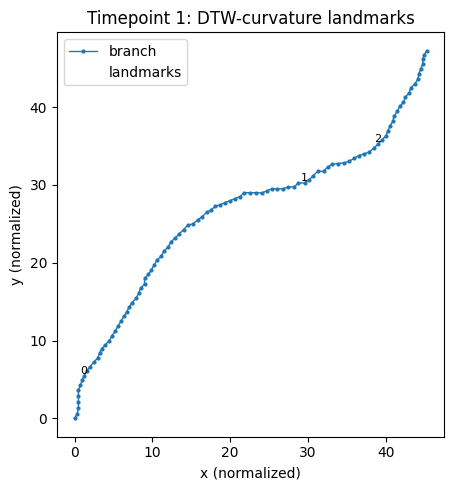

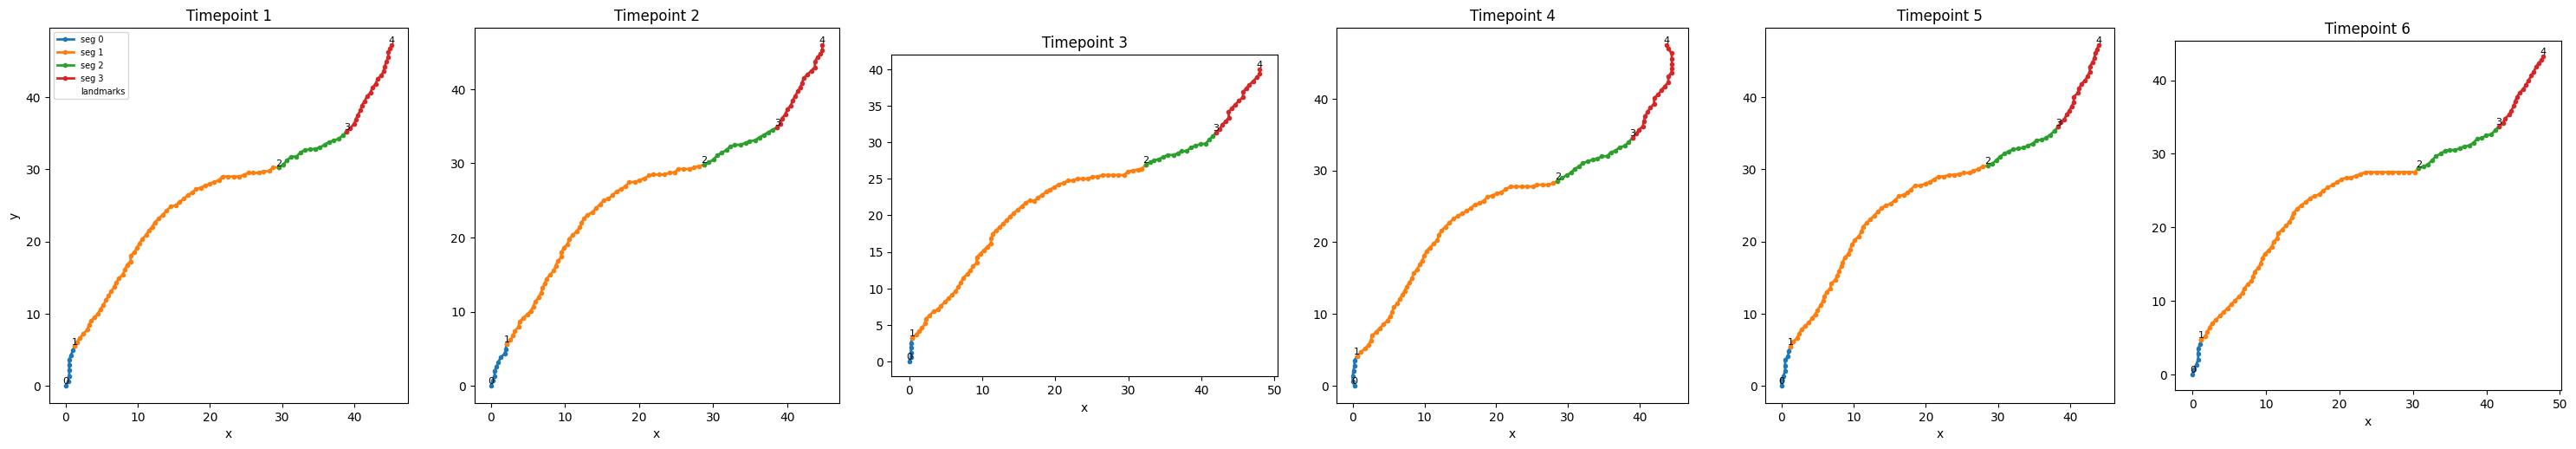

In [113]:
plot_branch_with_landmarks(0)
plot_branch_segments_multi_dtw()

In [114]:
import numpy as np
import matplotlib.pyplot as plt

def _to_xy(arr):
    """Ensure we have an (N, 2) array from arr that may be (N,), (N,2), (N,3)..."""
    arr = np.asarray(arr)
    if arr.ndim == 1:
        # Single point or flat list -> treat as x only
        return np.stack([arr, np.zeros_like(arr)], axis=1)
    if arr.shape[1] >= 2:
        return arr[:, :2]
    else:
        # Only one coordinate column -> pad y with zeros
        pad = np.zeros((arr.shape[0], 1), dtype=arr.dtype)
        return np.hstack([arr, pad])

def plot_branch_markers_fids(tp=0,
                             show_markers=True,
                             show_raw_fids=True,
                             show_snapped_fids=True,
                             annotate_fids=True):
    """
    Visualize a single timepoint:
    - normalized branch (nb)
    - markers (nm)
    - fiducials before and after snapping to the branch
    """
    # Convert to xy
    branch_xy  = _to_xy(nb[tp])
    markers_xy = _to_xy(nm[tp]) if len(nm[tp]) > 0 else None
    fids_xy    = _to_xy(nf[tp]) if len(nf[tp]) > 0 else None

    snapped_idx = np.asarray(cb_fids[tp], dtype=int)

    plt.figure(figsize=(5, 5))

    # Branch as polyline
    plt.plot(branch_xy[:, 0], branch_xy[:, 1], "-o", ms=2, lw=1, label="branch")

    # Markers
    if show_markers and markers_xy is not None:
        plt.scatter(markers_xy[:, 0], markers_xy[:, 1],
                    s=10, alpha=0.6, label="markers")

    # Raw fiducial points (before snapping)
    if show_raw_fids and fids_xy is not None:
        plt.scatter(fids_xy[:, 0], fids_xy[:, 1],
                    s=40, marker="x", label="fids (raw)")

    # Snapped fiducials on the branch
    if show_snapped_fids and snapped_idx.size > 0:
        snapped_xy = branch_xy[snapped_idx]
        plt.scatter(snapped_xy[:, 0], snapped_xy[:, 1],
                    s=60, marker="s", facecolors="none", label="fids (snapped)")

        if annotate_fids:
            for j, pt in enumerate(snapped_xy):
                x, y = pt[0], pt[1]
                plt.text(x, y, f"{j}", fontsize=8, ha="center", va="bottom")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")
    plt.title(f"Timepoint {tp + 1}: branch, markers, and fiducials")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


In [115]:
plot_branch_markers_fids(tp=0)

NameError: name 'nf' is not defined

In [ ]:
plot_branch_markers_fids(tp=1)

In [ ]:
def plot_cumdist_rescaling_multi_realx():
    """
    Multi-panel plot showing cumulative distance along the branch.
    X-axis = actual cumulative distance (unscaled vs scaled).
    Much more interpretable than using boundary indices.
    """

    T = len(cum_unscaled)
    fig, axes = plt.subplots(1, T, figsize=(5*T, 4), squeeze=False)

    for tp in range(T):
        ax = axes[0, tp]
        cu = np.asarray(cum_unscaled[tp])   # actual distances
        cs = np.asarray(cum_scaled[tp])     # scaled distances

        # Plot them as 1D tracks
        ax.plot(cu, np.zeros_like(cu), "-o", label="unscaled")
        ax.plot(cs, np.zeros_like(cs), "-o", label="scaled")

        # Vertical lines at actual distances
        for x in cu:
            ax.axvline(x, color="lightgray", linestyle=":", linewidth=0.5)

        ax.set_title(f"timepoint {tp+1}")
        ax.set_xlabel("cumulative distance (normalized units)")
        if tp == 0:
            ax.set_ylabel("baseline (just for plotting)")

        ax.set_yticks([])   # hide irrelevant y-axis
        ax.legend()

    plt.tight_layout()
    plt.show()
plot_cumdist_rescaling_multi_realx()

In [ ]:
def plot_branch_segments_multi():
    """
    Multi-panel plot: branch + segment visualization for ALL timepoints.
    Each timepoint gets its own subplot.
    """

    T = len(nb)   # numplot_branch_segments_multi()ber of timepoints
    fig, axes = plt.subplots(1, T, figsize=(5*T, 5), squeeze=False)

    for tp in range(T):
        ax = axes[0, tp]

        # Convert branch to XY only
        branch_xy = _to_xy(nb[tp])
        segs = segments_all[tp]
        fid_idx = np.asarray(cb_fids[tp], dtype=int)

        # Draw whole branch lightly
        ax.plot(branch_xy[:, 0], branch_xy[:, 1],
                "k--", alpha=0.3, lw=1)

        # Draw each segment in its own color
        for k, (a, b) in enumerate(segs):
            pts = branch_xy[a:b+1] if b >= a else branch_xy[b:a+1]
            ax.plot(pts[:, 0], pts[:, 1], "-o", lw=2, ms=3, label=f"seg {k}")

        # Overlay snapped fiducials
        if fid_idx.size > 0:
            snapped_xy = branch_xy[fid_idx]
            ax.scatter(snapped_xy[:, 0], snapped_xy[:, 1],
                       s=60, marker="s", facecolors="none", label="fiducials")
            for j, pt in enumerate(snapped_xy):
                x, y = pt[0], pt[1]
                ax.text(x, y, f"{j}", fontsize=8, ha="center", va="bottom")

        ax.set_aspect("equal", adjustable="box")
        ax.set_title(f"t = {tp+1}")
        ax.set_xlabel("x")
        if tp == 0:
            ax.set_ylabel("y")

        # Keep legend only on first subplot to avoid clutter
        if tp == 0:
            ax.legend(fontsize=7)
        else:
            ax.legend().remove()

    plt.tight_layout()
    plt.show()
plot_branch_segments_multi()

In [ ]:
import matplotlib.pyplot as plt

def plot_branch_smoothed_with_fids(tp=0, show_markers=False):
    """
    Plot, for a given timepoint:
    - original normalized branch (nb[tp])
    - smoothed branch used for curvature
    - automatically derived fiducials (cb_fids[tp])
    """
    branch_xy = _to_xy(nb[tp])
    branch_s  = smooth_branch(branch_xy, window=5)   # same window as curvature
    fid_idx   = np.asarray(cb_fids[tp], dtype=int)

    plt.figure(figsize=(5, 5))

    # Original branch
    plt.plot(branch_xy[:, 0], branch_xy[:, 1],
             "-o", ms=2, lw=1, label="branch (original)")

    # Smoothed branch
    plt.plot(branch_s[:, 0], branch_s[:, 1],
             "-o", ms=2, lw=1, alpha=0.7, label="branch (smoothed)")

    # Markers (optional, just to see where synapses lie)
    if show_markers and len(nm[tp]) > 0:
        mk_xy = _to_xy(nm[tp])
        plt.scatter(mk_xy[:, 0], mk_xy[:, 1],
                    s=10, alpha=0.6, label="markers")

    # Fiducials on the *original* branch
    if fid_idx.size > 0:
        fid_pts = branch_xy[fid_idx]
        plt.scatter(fid_pts[:, 0], fid_pts[:, 1],
                    s=60, marker="s", facecolors="none", label="auto fiducials")
        for j, pt in enumerate(fid_pts):
            x, y = pt[0], pt[1]
            plt.text(x, y, f"{j}", fontsize=8, ha="center", va="bottom")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")
    plt.title(f"Timepoint {tp+1}: original vs smoothed branch + auto fiducials")
    plt.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()


In [ ]:
plot_theta_alignment(tp=1)
plot_branch_with_marker_coords(tp=0)
plot_branch_with_marker_coords(tp=1)

In [ ]:
import numpy as np
from typing import List, Callable
import matplotlib.pyplot as plt

def _to_xy(arr):
    """Ensure array is (N, 2) from (N,), (N,2), (N,3,...)."""
    arr = np.asarray(arr)
    if arr.ndim == 1:
        return np.stack([arr, np.zeros_like(arr)], axis=1)
    if arr.shape[1] >= 2:
        return arr[:, :2]
    pad = np.zeros((arr.shape[0], 1), dtype=arr.dtype)
    return np.hstack([arr, pad])

def compute_arclength(branch_xy: np.ndarray):
    """
    Given branch points (N,2), return:
      s: arclength at each vertex (length N)
      L: total length
      t_norm: normalized arclength in [0,1]
    """
    branch_xy = _to_xy(branch_xy)
    diffs = np.diff(branch_xy, axis=0)
    seglen = np.linalg.norm(diffs, axis=1)
    s = np.concatenate([[0.0], np.cumsum(seglen)])
    L = float(s[-1]) if s[-1] > 0 else 1.0
    t_norm = s / L
    return s, L, t_norm

def resample_branch_equal_arclen(branch_xy: np.ndarray, n_samp: int = 200):
    """
    Resample the branch to n_samp points at equal arclength fractions in [0,1].
    Returns resampled points of shape (n_samp, 2) and the t grid.
    """
    branch_xy = _to_xy(branch_xy)
    s, L, t_norm = compute_arclength(branch_xy)

    t_grid = np.linspace(0.0, 1.0, n_samp)
    x = np.interp(t_grid, t_norm, branch_xy[:, 0])
    y = np.interp(t_grid, t_norm, branch_xy[:, 1])
    pts = np.stack([x, y], axis=1)
    return pts, t_grid

# ============================================================
# 1. Tangent angle representation (with smoothing)
# ============================================================

def compute_tangent_angles(branch_xy: np.ndarray,
                           n_samp: int = 200,
                           coord_smooth_window: int = 7,
                           theta_smooth_window: int = 11):
    """
    1) Resample branch to n_samp points along arclength in [0,1].
    2) Smooth coordinates along the curve (coord_smooth_window).
    3) Compute unit tangents via finite differences.
    4) Convert to angles theta in radians, unwrap to avoid π jumps.
    5) Smooth theta as a 1D signal (theta_smooth_window).

    Returns:
        theta_smooth: shape (n_samp,)
        t_grid:       shape (n_samp,) ∈ [0,1]
    """
    pts, t_grid = resample_branch_equal_arclen(branch_xy, n_samp=n_samp)
    N = pts.shape[0]

    # --- Smooth coordinates along arclength ---
    if coord_smooth_window >= 3 and coord_smooth_window % 2 == 1:
        kernel = np.ones(coord_smooth_window, dtype=float) / coord_smooth_window
        x = np.convolve(pts[:, 0], kernel, mode="same")
        y = np.convolve(pts[:, 1], kernel, mode="same")
        pts_s = np.stack([x, y], axis=1)
    else:
        pts_s = pts

    # --- Tangents via finite differences ---
    diffs = np.zeros_like(pts_s)
    if N >= 2:
        diffs[0]  = pts_s[1] - pts_s[0]
        diffs[-1] = pts_s[-1] - pts_s[-2]
    if N >= 3:
        diffs[1:-1] = (pts_s[2:] - pts_s[:-2]) * 0.5

    norms = np.linalg.norm(diffs, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    tangents = diffs / norms

    theta = np.arctan2(tangents[:, 1], tangents[:, 0])
    theta_unwrapped = np.unwrap(theta)

    # --- Smooth theta itself ---
    if theta_smooth_window >= 3 and theta_smooth_window % 2 == 1:
        k = np.ones(theta_smooth_window, dtype=float) / theta_smooth_window
        theta_smooth = np.convolve(theta_unwrapped, k, mode="same")
    else:
        theta_smooth = theta_unwrapped

    return theta_smooth, t_grid

# ============================================================
# 2. Simple DTW implementation for 1D sequences
# ============================================================

def dtw_path(seq1: np.ndarray, seq2: np.ndarray):
    """
    Classic DTW for 1D sequences.
    Returns a list of (i, j) indices giving the alignment path.
    """
    seq1 = np.asarray(seq1, dtype=float)
    seq2 = np.asarray(seq2, dtype=float)
    n, m = len(seq1), len(seq2)

    # cost matrix
    D = np.full((n + 1, m + 1), np.inf)
    D[0, 0] = 0.0

    # backpointers: 0 = diag, 1 = up, 2 = left
    trace = np.zeros((n + 1, m + 1), dtype=np.int8)

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = (seq1[i - 1] - seq2[j - 1]) ** 2
            choices = (D[i - 1, j - 1], D[i - 1, j], D[i, j - 1])
            k = int(np.argmin(choices))
            D[i, j] = cost + choices[k]
            trace[i, j] = k

    # backtrack
    i, j = n, m
    path = []
    while i > 0 and j > 0:
        path.append((i - 1, j - 1))
        move = trace[i, j]
        if move == 0:   # diag
            i -= 1
            j -= 1
        elif move == 1: # up
            i -= 1
        else:           # left
            j -= 1

    path.reverse()
    return path

# ============================================================
# 3. Build monotone warping function from DTW path
# ============================================================

def build_warp_from_dtw(t_ref: np.ndarray,
                        t_src: np.ndarray,
                        path: List[tuple]):
    """
    Given:
      t_ref: positions in [0,1] for reference sequence (len n_ref)
      t_src: positions in [0,1] for source sequence (len n_src)
      path: list of (i_ref, j_src) pairs from DTW

    Build a monotone, piecewise-linear warp f: t_src -> t_ref.

    Returns:
      warp_func(t) -> t_ref
      t_src_arr: sample t_src points used
      t_ref_arr: corresponding t_ref points
    """
    t_src_samples = []
    t_ref_samples = []

    last_src = None
    for i_ref, j_src in path:
        src_t = float(t_src[j_src])
        ref_t = float(t_ref[i_ref])
        if last_src is None or src_t > last_src:
            t_src_samples.append(src_t)
            t_ref_samples.append(ref_t)
            last_src = src_t
        else:
            # multiple matches to the same src index: update last ref_t
            t_ref_samples[-1] = ref_t

    # Ensure endpoints are covered
    if 0.0 not in t_src_samples:
        t_src_samples.insert(0, 0.0)
        t_ref_samples.insert(0, t_ref[0])
    if 1.0 not in t_src_samples:
        t_src_samples.append(1.0)
        t_ref_samples.append(t_ref[-1])

    t_src_arr = np.array(t_src_samples)
    t_ref_arr = np.array(t_ref_samples)

    def warp_func(t: float) -> float:
        return float(np.interp(t, t_src_arr, t_ref_arr,
                               left=t_ref_arr[0],
                               right=t_ref_arr[-1]))

    return warp_func, t_src_arr, t_ref_arr

# ============================================================
# 4. Main pipeline: branches, markers, DTW alignment, canonical distances
# ============================================================

# 4.1 Load raw branch + markers, then normalize & scale
raw_branch = _branch_points_from_csvs(settings)
raw_markers, raw_fids_typed = read_markers_csv_list(
    settings.marker_csvs,
    settings.num_channels
)

# Strip types for markers into parallel arrays
raw_marker_coords_only = [[m[1] for m in tp] for tp in raw_markers]
raw_marker_types_only  = [[m[0] for m in tp] for tp in raw_markers]

# Normalize & scale (no fiducials needed here)
nb, nm = [], []
for i in range(settings.n_timepoints):
    # If _normalize_and_scale needs fiducials, pass an empty list.
    b, m, _ = _normalize_and_scale(
        raw_branch[i],
        raw_marker_coords_only[i],
        [],  # no manual fiducials
        settings.scaling_factor
    )
    nb.append(b)
    nm.append(m)

# 4.2 Map markers to nearest branch vertex (for arclength parameter)
def nearest_indices(points, branch):
    idxs = []
    for p in points:
        dists = [euc_xy(p, q) for q in branch]
        idxs.append(int(np.argmin(dists)))
    return idxs

cb_markers = []
for i in range(settings.n_timepoints):
    cb_markers.append(nearest_indices(nm[i], nb[i]))

# 4.3 Compute arclength + tangent angles for each timepoint
n_samp_theta = 200  # number of samples for angle representation
theta_all = []
tgrid_all = []
s_all = []
L_all = []
t_norm_all = []

for i in range(settings.n_timepoints):
    branch_xy = _to_xy(nb[i])
    # arclength / normalized arclength per vertex
    s_i, L_i, t_norm_i = compute_arclength(branch_xy)
    s_all.append(s_i)
    L_all.append(L_i)
    t_norm_all.append(t_norm_i)

    # tangent angles as function of normalized arclength
    theta_i, t_grid_i = compute_tangent_angles(
        branch_xy,
        n_samp=n_samp_theta,
        coord_smooth_window=7,
        theta_smooth_window=11,
    )
    theta_all.append(theta_i)
    tgrid_all.append(t_grid_i)

# 4.4 Choose reference timepoint and build warp functions with DTW
ref_tp = 0
theta_ref = theta_all[ref_tp]
t_ref_grid = tgrid_all[ref_tp]
L_ref = L_all[ref_tp]

warp_funcs: List[Callable[[float], float]] = []
warp_src_samples: List[np.ndarray] = []  # per-tp t_src_arr
warp_ref_samples: List[np.ndarray] = []  # per-tp t_ref_arr

for tp in range(settings.n_timepoints):
    if tp == ref_tp:
        # Identity mapping for reference
        warp_funcs.append(lambda t, _tg=t_ref_grid: float(t))
        warp_src_samples.append(t_ref_grid.copy())
        warp_ref_samples.append(t_ref_grid.copy())
        continue

    theta_src = theta_all[tp]
    t_src_grid = tgrid_all[tp]

    # DTW between reference and this timepoint in angle space
    path = dtw_path(theta_ref, theta_src)

    # Build monotone warp f_tp: t_src -> t_ref and keep sample arrays
    f_tp, t_src_arr, t_ref_arr = build_warp_from_dtw(t_ref_grid, t_src_grid, path)
    warp_funcs.append(f_tp)
    warp_src_samples.append(t_src_arr)
    warp_ref_samples.append(t_ref_arr)

# 4.5 Compute canonical marker distances along reference branch
#     final_marker_distance[tp][k] ~ distance along reference branch (0..L_ref)
final_marker_distance: List[List[float]] = []

for tp in range(settings.n_timepoints):
    branch_xy = _to_xy(nb[tp])
    s_i, L_i, t_norm_i = compute_arclength(branch_xy)
    f_tp = warp_funcs[tp]

    fm = []
    for m_idx in cb_markers[tp]:
        # normalized arclength of marker on this branch
        t_marker = float(t_norm_i[m_idx])
        # Warp into reference's parameter space
        t_canon = f_tp(t_marker)
        # Convert to distance along reference branch
        d_canon = t_canon * L_ref
        fm.append(d_canon)
    final_marker_distance.append(fm)

# ============================================================
# 5. DTW-derived landmarks (explicit fiducials)
# ============================================================

K = 4  # number of internal landmarks you want
t_ref_landmarks = np.linspace(0.0, 1.0, K + 2)[1:-1]  # exclude exact 0 and 1

landmarks_all: List[List[int]] = []  # per timepoint: list of branch indices

for tp in range(settings.n_timepoints):
    branch_xy = _to_xy(nb[tp])
    s_i, L_i, t_norm_i = compute_arclength(branch_xy)

    if tp == ref_tp:
        # For reference, t_src == t_ref, so t_src_landmarks = t_ref_landmarks
        t_src_landmarks = t_ref_landmarks
    else:
        # Invert warp: for each t_ref_landmark, find t_src such that f_tp(t_src) ~ t_ref_landmark
        t_src_arr = warp_src_samples[tp]
        t_ref_arr = warp_ref_samples[tp]
        t_src_landmarks = np.interp(t_ref_landmarks, t_ref_arr, t_src_arr)

    # Convert t_src_landmarks (in [0,1]) to nearest branch indices
    landmark_indices_tp = [
        int(np.argmin(np.abs(t_norm_i - t_src_l))) for t_src_l in t_src_landmarks
    ]
    # ensure sorted, unique
    landmark_indices_tp = sorted(set(landmark_indices_tp))
    landmarks_all.append(landmark_indices_tp)

# ============================================================
# 6. Optional plotting helpers
# ============================================================

def plot_theta_alignment(tp: int = 1):
    """
    Visualize tangent-angle signals for reference vs another timepoint.
    Helps debug the DTW alignment.
    """
    theta_ref = theta_all[ref_tp]
    t_ref = tgrid_all[ref_tp]
    theta_src = theta_all[tp]
    t_src = tgrid_all[tp]

    plt.figure(figsize=(6, 4))
    plt.plot(t_ref, theta_ref, label=f"theta ref (tp={ref_tp+1})")
    plt.plot(t_src, theta_src, label=f"theta tp={tp+1}", alpha=0.7)
    plt.xlabel("normalized arclength t")
    plt.ylabel("tangent angle (rad, unwrapped)")
    plt.title("Tangent-angle profiles")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_branch_with_marker_coords(tp: int = 0):
    """
    Plot branch with markers colored by canonical distance final_marker_distance.
    """
    branch_xy = _to_xy(nb[tp])
    markers = nm[tp]
    m_idxs = cb_markers[tp]
    fm = final_marker_distance[tp]

    plt.figure(figsize=(5, 5))
    plt.plot(branch_xy[:, 0], branch_xy[:, 1], "-o", ms=2, lw=1, label="branch")
    if markers:
        markers_xy = np.array(markers)
        sc = plt.scatter(markers_xy[:, 0], markers_xy[:, 1],
                         c=fm, s=20, cmap="viridis", label="markers (canon. dist)")
        plt.colorbar(sc, label="canonical distance along ref branch")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")
    plt.title(f"Timepoint {tp+1}: markers colored by canonical distance")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_branch_with_landmarks(tp: int = 0):
    """
    Plot branch and show DTW-derived landmarks as squares, for sanity-checking.
    """
    branch_xy = _to_xy(nb[tp])
    lm_idx = landmarks_all[tp]

    plt.figure(figsize=(5, 5))
    plt.plot(branch_xy[:, 0], branch_xy[:, 1], "-o", ms=2, lw=1, label="branch")

    if lm_idx:
        lm_pts = branch_xy[lm_idx]
        plt.scatter(lm_pts[:, 0], lm_pts[:, 1],
                    s=60, marker="s", facecolors="none", label="DTW landmarks")
        for j, (x, y) in enumerate(lm_pts):
            plt.text(x, y, f"{j}", fontsize=8, ha="center", va="bottom")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (normalized)")
    plt.ylabel("y (normalized)")
    plt.title(f"Timepoint {tp+1}: DTW-derived landmarks")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [116]:
def plot_branch_segments_multi_dtw(K=4):
    """
    Multi-panel plot showing:
       - branch
       - DTW-derived landmarks (squares)
       - segments between these landmarks
    Works with the new DTW/tangent-angle alignment pipeline.
    """

    T = len(nb)   # number of timepoints
    fig, axes = plt.subplots(1, T, figsize=(5*T, 5), squeeze=False)

    for tp in range(T):
        ax = axes[0, tp]

        branch_xy = _to_xy(nb[tp])

        # --------------------------
        # DTW-derived fiducials
        # --------------------------
        fid_idx = sorted(landmarks_all[tp])  # list of indices
        fid_idx = [0] + fid_idx + [len(branch_xy)-1]  # include endpoints

        # Build segments as (start_idx, end_idx)
        segs = []
        for a, b in zip(fid_idx[:-1], fid_idx[1:]):
            segs.append((a, b))

        # --------------------------
        # Plot full branch
        # --------------------------
        ax.plot(branch_xy[:, 0], branch_xy[:, 1],
                "k--", alpha=0.3, lw=1)

        # --------------------------
        # Plot segments
        # --------------------------
        for k, (a, b) in enumerate(segs):
            lo, hi = min(a,b), max(a,b)
            pts = branch_xy[lo:hi+1]
            ax.plot(pts[:, 0], pts[:, 1],
                    "-o", lw=2, ms=3, label=f"seg {k}")

        # --------------------------
        # Plot fiducials (landmarks)
        # --------------------------
        lm = branch_xy[fid_idx]
        ax.scatter(lm[:, 0], lm[:, 1],
                   s=60, marker="s", facecolors="none",
                   label="DTW landmarks")

        # Add label numbers
        for j, (x, y) in enumerate(lm):
            ax.text(x, y, f"{j}", fontsize=8, ha="center", va="bottom")

        # --------------------------
        # Plot settings
        # --------------------------
        ax.set_aspect("equal", adjustable="box")
        ax.set_title(f"Timepoint {tp+1}")
        ax.set_xlabel("x")
        if tp == 0:
            ax.set_ylabel("y")

        if tp == 0:
            ax.legend(fontsize=7)
        else:
            ax.legend().remove()

    plt.tight_layout()
    plt.show()


In [117]:
from scipy.signal import find_peaks

def curvature_scores_along_branch(branch_xy: np.ndarray,
                                  n_samp: int = 200,
                                  coord_smooth_window: int = 9,
                                  curv_smooth_window: int = 9):
    """
    Compute a smooth 'curvature magnitude' signal κ(t) along normalized arclength
    for a single branch.

    Steps:
      1) Resample branch to n_samp points at equal arclength fractions t ∈ [0,1].
      2) Smooth coordinates along the curve.
      3) Compute discrete second derivative p[i+1] - 2 p[i] + p[i-1].
      4) Use ||second derivative|| as a curvature-like magnitude.
      5) Smooth κ(t) as a 1D signal.

    Returns:
      kappa_smooth: shape (n_samp,) curvature-like score
      t_grid:       shape (n_samp,) ∈ [0,1]
    """
    pts, t_grid = resample_branch_equal_arclen(branch_xy, n_samp=n_samp)
    N = pts.shape[0]

    # --- smooth coordinates ---
    if coord_smooth_window >= 3 and coord_smooth_window % 2 == 1:
        kcoord = np.ones(coord_smooth_window, dtype=float) / coord_smooth_window
        x = np.convolve(pts[:, 0], kcoord, mode="same")
        y = np.convolve(pts[:, 1], kcoord, mode="same")
        pts_s = np.stack([x, y], axis=1)
    else:
        pts_s = pts

    # --- second derivative (index-wise) ---
    d2 = np.zeros((N, 2), dtype=float)
    if N >= 3:
        core = pts_s[2:, :] - 2 * pts_s[1:-1, :] + pts_s[:-2, :]
        d2[1:-1, :] = core

    kappa = np.linalg.norm(d2, axis=1)

    # --- smooth curvature signal ---
    if curv_smooth_window >= 3 and curv_smooth_window % 2 == 1:
        kcurv = np.ones(curv_smooth_window, dtype=float) / curv_smooth_window
        kappa_smooth = np.convolve(kappa, kcurv, mode="same")
    else:
        kappa_smooth = kappa

    return kappa_smooth, t_grid


In [118]:
# ============================================================
# 5. DTW-derived landmarks based on major curvature turns
# ============================================================

K = 4            # number of internal curvature-based landmarks
end_clip_frac = 0.05  # ignore first/last 5% of arclength when picking peaks
min_peak_frac = 0.1   # optional: ignore very tiny curvature peaks (fraction of max)
min_idx_sep_frac = 0.05  # minimum index separation as fraction of n_samp

# --- 5.1: Find curvature-based landmarks ON THE REFERENCE BRANCH ONLY ---

branch_ref_xy = _to_xy(nb[ref_tp])

# curvature-like signal κ_ref(t) on [0,1]
kappa_ref, t_ref_curv = curvature_scores_along_branch(
    branch_ref_xy,
    n_samp=200,
    coord_smooth_window=9,
    curv_smooth_window=9,
)

# mask out tips in κ_ref for peak finding
kappa_for_peaks = kappa_ref.copy()
tip_mask = (t_ref_curv <= end_clip_frac) | (t_ref_curv >= 1.0 - end_clip_frac)
kappa_for_peaks[tip_mask] = 0.0

# min index separation between landmarks
min_idx_sep = max(1, int(len(kappa_for_peaks) * min_idx_sep_frac))

# find all local maxima in curvature
peaks_all, _ = find_peaks(kappa_for_peaks, distance=min_idx_sep)

if len(peaks_all) == 0:
    # fallback: if somehow no peaks, revert to equal spacing
    t_ref_landmarks = np.linspace(0.0, 1.0, K + 2)[1:-1]
else:
    # optionally filter out very small peaks
    peak_vals = kappa_for_peaks[peaks_all]
    max_val = float(peak_vals.max())
    keep_mask = peak_vals >= (min_peak_frac * max_val)
    peaks_kept = peaks_all[keep_mask]

    if len(peaks_kept) == 0:
        peaks_kept = peaks_all  # if filtering killed everything, keep all

    # sort by strength, take top K, then sort by position
    if len(peaks_kept) > K:
        order = np.argsort(peak_vals[keep_mask])[::-1]  # descending by height
        chosen = peaks_kept[order[:K]]
    else:
        chosen = peaks_kept

    chosen = np.sort(chosen)
    t_ref_landmarks = t_ref_curv[chosen]

# t_ref_landmarks are canonical "major curvature turn" positions
# in normalized arclength on the reference branch.

# --- 5.2: Map those curvature landmarks to every timepoint via DTW warp inverse ---

landmarks_all: List[List[int]] = []  # per timepoint: list of branch indices

for tp in range(settings.n_timepoints):
    branch_xy = _to_xy(nb[tp])
    s_i, L_i, t_norm_i = compute_arclength(branch_xy)

    if tp == ref_tp:
        # reference: its own t-landmarks are already in reference coordinates
        t_src_landmarks = t_ref_landmarks
    else:
        # invert the warp using (t_src_arr, t_ref_arr) from DTW
        t_src_arr = warp_src_samples[tp]
        t_ref_arr = warp_ref_samples[tp]

        # for each t_ref_landmark, find t_src such that f_tp(t_src) ≈ t_ref_landmark
        t_src_landmarks = np.interp(t_ref_landmarks, t_ref_arr, t_src_arr)

    # convert normalized arclength positions to nearest branch vertex indices
    landmark_indices_tp = [
        int(np.argmin(np.abs(t_norm_i - t_src_l)))
        for t_src_l in t_src_landmarks
    ]

    # ensure sorted and unique (in case of very short branches / rounding)
    landmark_indices_tp = sorted(set(landmark_indices_tp))
    landmarks_all.append(landmark_indices_tp)


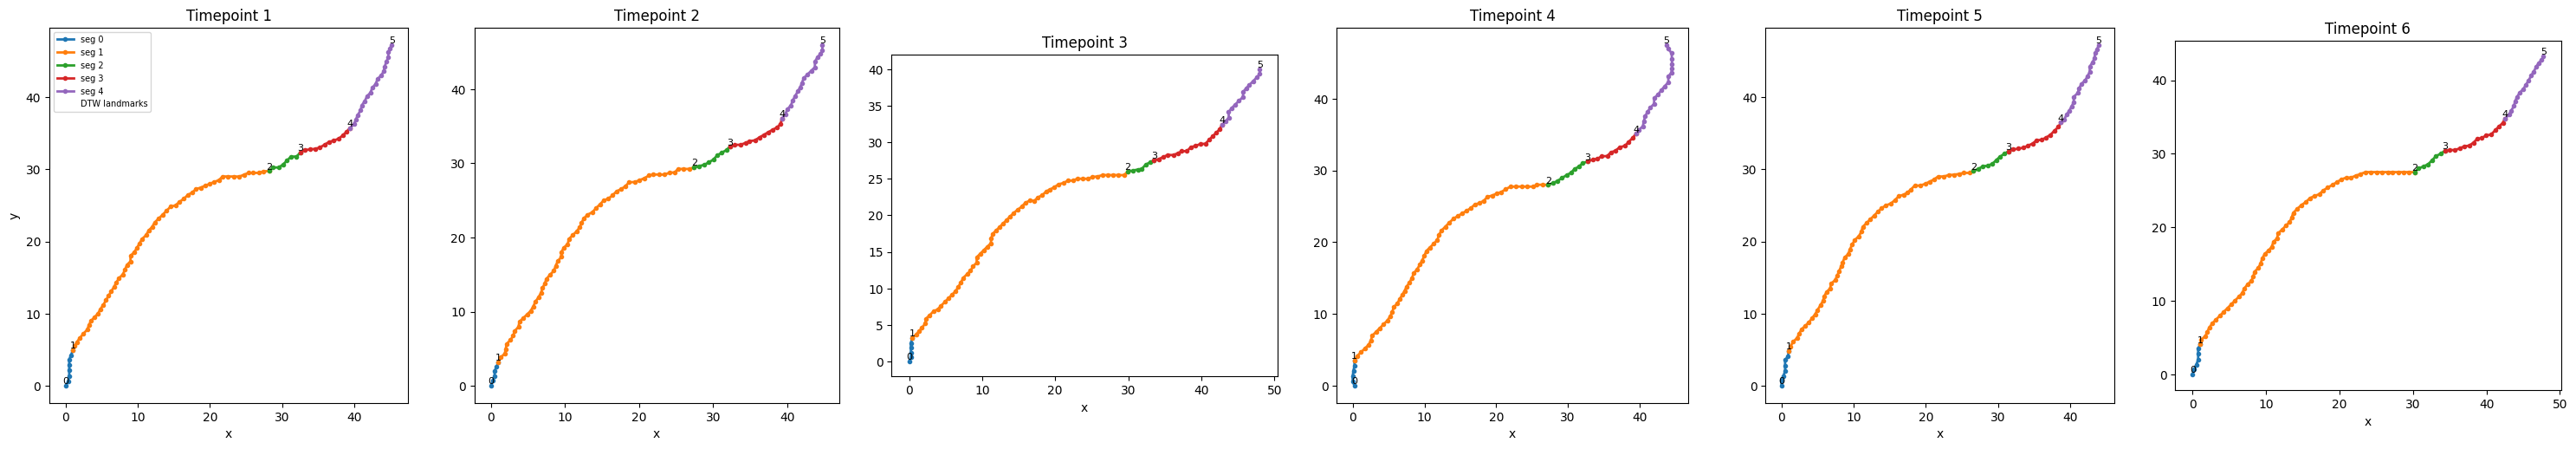

In [119]:
plot_branch_segments_multi_dtw()

In [83]:
# ============================================================
# 5. DTW-derived landmarks based on major curvature turns
#    (adaptive, but with stricter thresholds + max cap)
# ============================================================

end_clip_frac    = 0.08     # ignore first/last 8% of arclength
min_peak_frac    = 0.25     # keep peaks >= 25% of max curvature
min_idx_sep_frac = 0.10     # peaks must be at least 10% of samples apart
max_landmarks    = 3        # hard cap on number of curvature landmarks
fallback_K       = 2        # if everything fails, use this many evenly spaced

# --- 5.1: Find curvature-based landmarks ON THE REFERENCE BRANCH ONLY ---

branch_ref_xy = _to_xy(nb[ref_tp])

kappa_ref, t_ref_curv = curvature_scores_along_branch(
    branch_ref_xy,
    n_samp=200,
    coord_smooth_window=11,   # a bit more smoothing
    curv_smooth_window=11,
)

kappa_for_peaks = kappa_ref.copy()
tip_mask = (t_ref_curv <= end_clip_frac) | (t_ref_curv >= 1.0 - end_clip_frac)
kappa_for_peaks[tip_mask] = 0.0

min_idx_sep = max(1, int(len(kappa_for_peaks) * min_idx_sep_frac))

peaks_all, _ = find_peaks(kappa_for_peaks, distance=min_idx_sep)

if len(peaks_all) == 0:
    # fallback: branch is nearly straight or too noisy
    t_ref_landmarks = np.linspace(0.0, 1.0, fallback_K + 2)[1:-1]
else:
    peak_vals = kappa_for_peaks[peaks_all]
    max_val   = float(peak_vals.max())
    height_thresh = min_peak_frac * max_val

    keep_mask  = peak_vals >= height_thresh
    peaks_kept = peaks_all[keep_mask]

    if len(peaks_kept) == 0:
        peaks_kept = peaks_all  # if threshold killed everything, keep all

    # If still too many, keep only the strongest `max_landmarks` peaks
    if len(peaks_kept) > max_landmarks:
        vals_kept = peak_vals[keep_mask] if keep_mask.any() else peak_vals
        order = np.argsort(vals_kept)[::-1]  # descending by height
        chosen_idx = order[:max_landmarks]
        peaks_chosen = peaks_kept[chosen_idx]
    else:
        peaks_chosen = peaks_kept

    peaks_chosen = np.sort(peaks_chosen)
    t_ref_landmarks = t_ref_curv[peaks_chosen]

# --- 5.2: Map those curvature landmarks to every timepoint via DTW warp inverse ---

landmarks_all: List[List[int]] = []

for tp in range(settings.n_timepoints):
    branch_xy = _to_xy(nb[tp])
    s_i, L_i, t_norm_i = compute_arclength(branch_xy)

    if tp == ref_tp:
        t_src_landmarks = t_ref_landmarks
    else:
        t_src_arr = warp_src_samples[tp]
        t_ref_arr = warp_ref_samples[tp]
        t_src_landmarks = np.interp(t_ref_landmarks, t_ref_arr, t_src_arr)

    landmark_indices_tp = [
        int(np.argmin(np.abs(t_norm_i - t_src_l)))
        for t_src_l in t_src_landmarks
    ]
    landmark_indices_tp = sorted(set(landmark_indices_tp))
    landmarks_all.append(landmark_indices_tp)


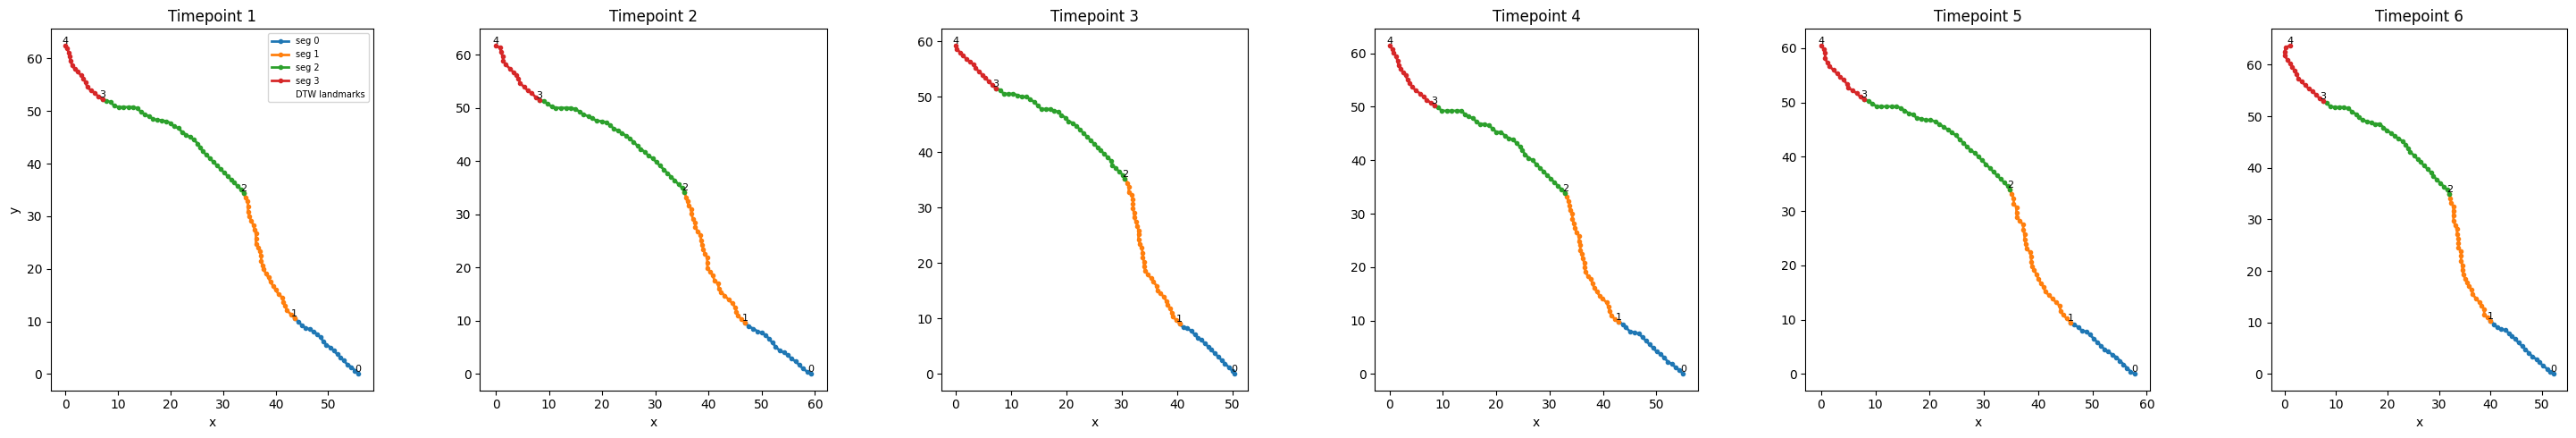

In [84]:
plot_branch_segments_multi_dtw()